In [38]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
import pathlib
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.3
The following GPU devices are available: /device:GPU:0


In [39]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to C:\Users\miron\AppData\Local\Temp\tmpa2yj5xgs.jpg.


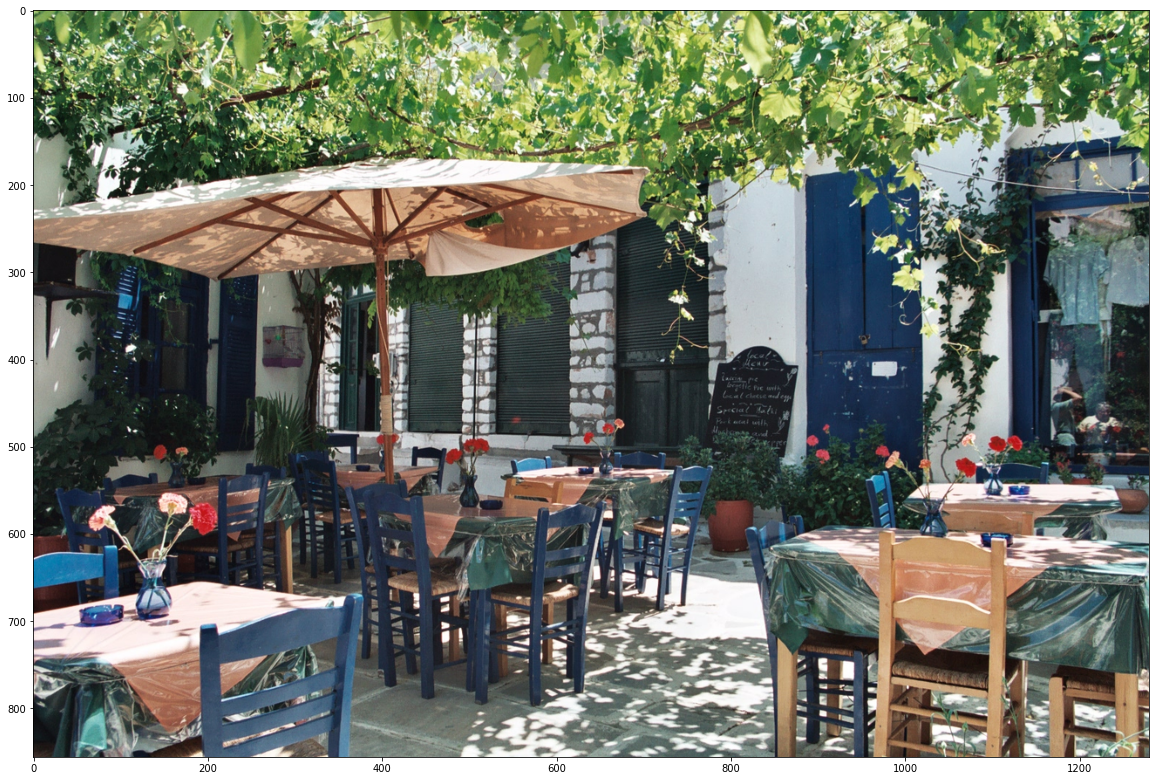

In [40]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [83]:
module_handle2 = "https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1"
detector2 = hub.load(module_handle2)

In [73]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
# module_handle = 'http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_snapshot_serengeti_2020_06_10.tar.gz'
# module_handle = "https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1"
detector = hub.load(module_handle).signatures['default']
# detector = hub.load(module_handle)

# def load_model(model_name):
#   base_url = 'http://download.tensorflow.org/models/object_detection/'
#   model_file = model_name + '.tar.gz'
#   model_dir = tf.keras.utils.get_file(
#     fname=model_name,
#     origin=base_url + model_file,
#     untar=True)

#   model_dir = pathlib.Path(model_dir)/"saved_model"
#   model = tf.saved_model.load(str(model_dir))
#   model = model.signatures['serving_default']

#   return model
# faster_rcnn_model_name = 'faster_rcnn_resnet101_snapshot_serengeti_2020_06_10'
# detector = load_model(faster_rcnn_model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [84]:
# detector1 = detector
detector = detector2

In [77]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [99]:
def run_detector(detector, path):
  img = load_img(path)

#   converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  converted_img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
#       result["detection_class_entities"], 
      result["detection_classes"], 
      (result["detection_scores"][0]))

  display_image(image_with_boxes)

In [92]:
detector1(tf.image.convert_image_dtype(load_img("D:\ML AI test\AI Factory\krustovishte.jpeg"), tf.float32)[tf.newaxis, ...])["detection_scores"]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.6311726 , 0.581431  , 0.503013  , 0.4804538 , 0.3941597 ,
       0.39335316, 0.36188358, 0.35783798, 0.35292858, 0.35173598,
       0.3211784 , 0.31155407, 0.3032    , 0.2792677 , 0.25934482,
       0.25254056, 0.24293867, 0.23794493, 0.23017979, 0.2168733 ,
       0.21398537, 0.2116858 , 0.20743857, 0.20139432, 0.20038737,
       0.181135  , 0.18005902, 0.1794415 , 0.17264812, 0.16783087,
       0.16621593, 0.16007581, 0.15905245, 0.15701064, 0.14551066,
       0.14500308, 0.13910277, 0.13817781, 0.137171  , 0.1308072 ,
       0.1294243 , 0.12754518, 0.12709996, 0.12667343, 0.12508358,
       0.12410143, 0.12356854, 0.12323111, 0.11377837, 0.11300233,
       0.10533106, 0.10405683, 0.10332876, 0.09563052, 0.0946214 ,
       0.09321311, 0.08680709, 0.08285403, 0.08110006, 0.08068524,
       0.08036854, 0.07989506, 0.07860827, 0.07677159, 0.07236573,
       0.07007667, 0.06916695, 0.06714772, 0.06657962, 0.06427696,
       0.06247

In [95]:
detector(tf.image.convert_image_dtype(load_img("D:\ML AI test\AI Factory\krustovishte.jpeg"), tf.uint8)[tf.newaxis, ...])["detection_scores"][0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.74944127, 0.72456414, 0.71045506, 0.69667417, 0.6874521 ,
       0.6856428 , 0.65441567, 0.6251261 , 0.6002029 , 0.5982597 ,
       0.5967297 , 0.58292556, 0.5777681 , 0.5759892 , 0.56186086,
       0.54015195, 0.5391775 , 0.53881013, 0.53157055, 0.5170698 ,
       0.51138437, 0.51002544, 0.47999424, 0.4776361 , 0.4745003 ,
       0.45572042, 0.4489629 , 0.44872957, 0.41445503, 0.40297213,
       0.39865997, 0.39859667, 0.39377144, 0.39111012, 0.38541335,
       0.38074946, 0.38066664, 0.37561828, 0.37123352, 0.3580012 ,
       0.35572335, 0.35470614, 0.35433868, 0.35170013, 0.3477762 ,
       0.34706032, 0.3440103 , 0.32496795, 0.3207971 , 0.31967533,
       0.27900785, 0.27255875, 0.2695991 , 0.26901153, 0.26224375,
       0.26154858, 0.25956076, 0.25732332, 0.251578  , 0.25117886,
       0.25099495, 0.24811774, 0.24719092, 0.24346444, 0.24134073,
       0.23931317, 0.23786624, 0.23664135, 0.23617864, 0.23469985,
       0.22758

In [100]:
run_detector(detector, downloaded_image_path)

Found 1 objects.
Inference time:  0.5699396133422852
Font not found, using default font.


ValueError: too many values to unpack (expected 4)

In [56]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  "https://abc.bg/f/pictures/0/96b3a3f3e110610192e5efe01121e203.jpg",
    
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)
def detect_img_by_path(image_path):
  start_time = time.time()
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

In [57]:
detect_img(image_urls[0])

Image downloaded to C:\Users\miron\AppData\Local\Temp\tmpk1i6sasp.jpg.


ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[[0.94117653 0.8588236  0.63529414]
   [0.94117653 0.8588236  0.63529414]
   [0.9450981  0.86274517 0.6392157 ]
   ...
   [0.95294124 0.8705883  0.654902  ]
   [0.9568628  0.86666673 0.654902  ]
   [0.9568628  0.86666673 0.654902  ]]

  [[0.94117653 0.8588236  0.63529414]
   [0.94117653 0.8588236  0.63529414]
   [0.9450981  0.86274517 0.6392157 ]
   ...
   [0.95294124 0.8705883  0.654902  ]
   [0.9568628  0.86666673 0.654902  ]
   [0.95294124 0.86274517 0.6509804 ]]

  [[0.94117653 0.8588236  0.63529414]
   [0.94117653 0.8588236  0.63529414]
   [0.9450981  0.86274517 0.6392157 ]
   ...
   [0.9490197  0.86666673 0.6509804 ]
   [0.95294124 0.86274517 0.6509804 ]
   [0.95294124 0.86274517 0.6509804 ]]

  ...

  [[0.94117653 0.8588236  0.6431373 ]
   [0.94117653 0.8588236  0.6431373 ]
   [0.94117653 0.8588236  0.6431373 ]
   ...
   [0.94117653 0.8588236  0.6431373 ]
   [0.93725497 0.854902   0.6392157 ]
   [0.93725497 0.854902   0.6392157 ]]

  [[0.9490197  0.86666673 0.6509804 ]
   [0.94117653 0.8588236  0.6431373 ]
   [0.94117653 0.8588236  0.6431373 ]
   ...
   [0.94117653 0.8588236  0.6431373 ]
   [0.93725497 0.854902   0.6392157 ]
   [0.93725497 0.854902   0.6392157 ]]

  [[0.95294124 0.8705883  0.654902  ]
   [0.9450981  0.86274517 0.64705884]
   [0.9450981  0.86274517 0.64705884]
   ...
   [0.94117653 0.8588236  0.6431373 ]
   [0.93725497 0.854902   0.6392157 ]
   [0.93725497 0.854902   0.6392157 ]]]], shape=(1, 480, 640, 3), dtype=float32))
  input_signature: (
    TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name=None)).

Image downloaded to C:\Users\miron\AppData\Local\Temp\tmp3jsxsak1.jpg.
Found 100 objects.
Inference time:  1.259265661239624
Font not found, using default font.
Inference time: 1.5580904483795166


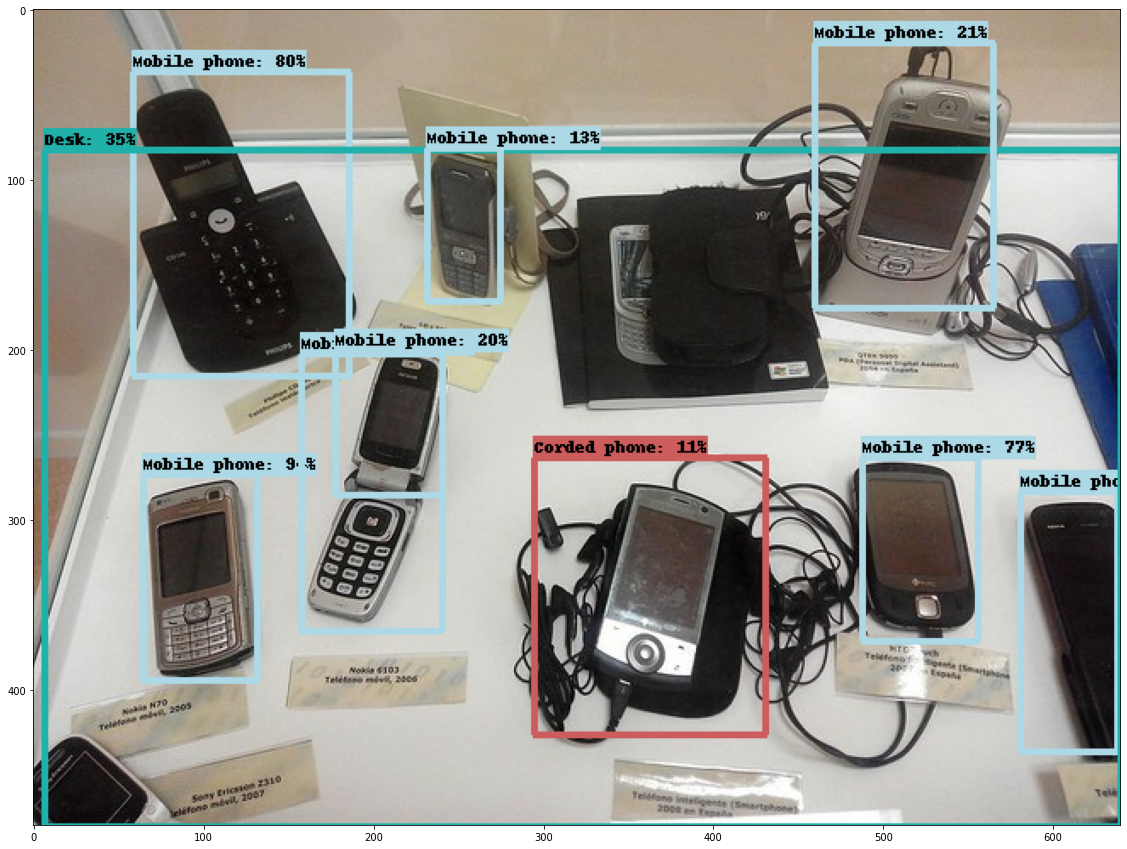

In [48]:
detect_img(image_urls[1])

Image downloaded to C:\Users\miron\AppData\Local\Temp\tmpfkyy44zm.jpg.
Found 100 objects.
Inference time:  1.284808874130249
Font not found, using default font.
Inference time: 1.6989741325378418


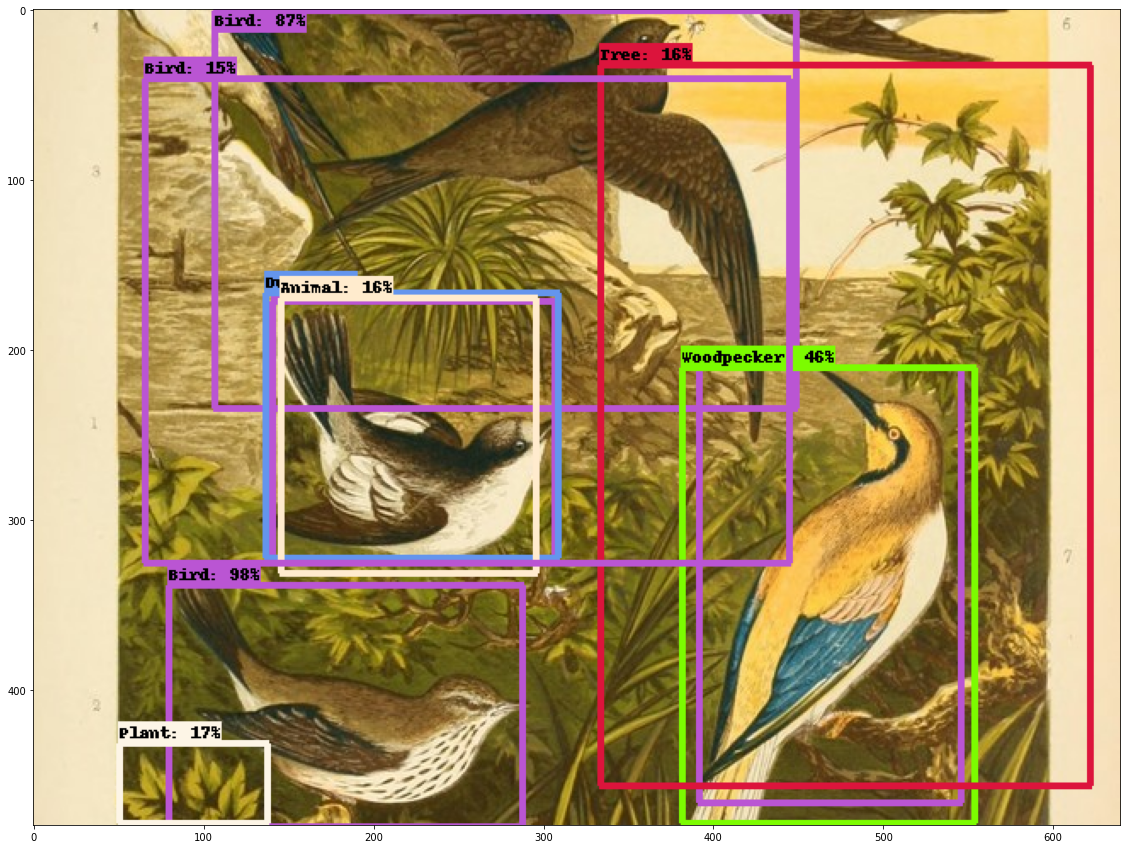

In [49]:
detect_img(image_urls[2])

Found 100 objects.
Inference time:  1.2914013862609863
Font not found, using default font.
Inference time: 1.3371379375457764


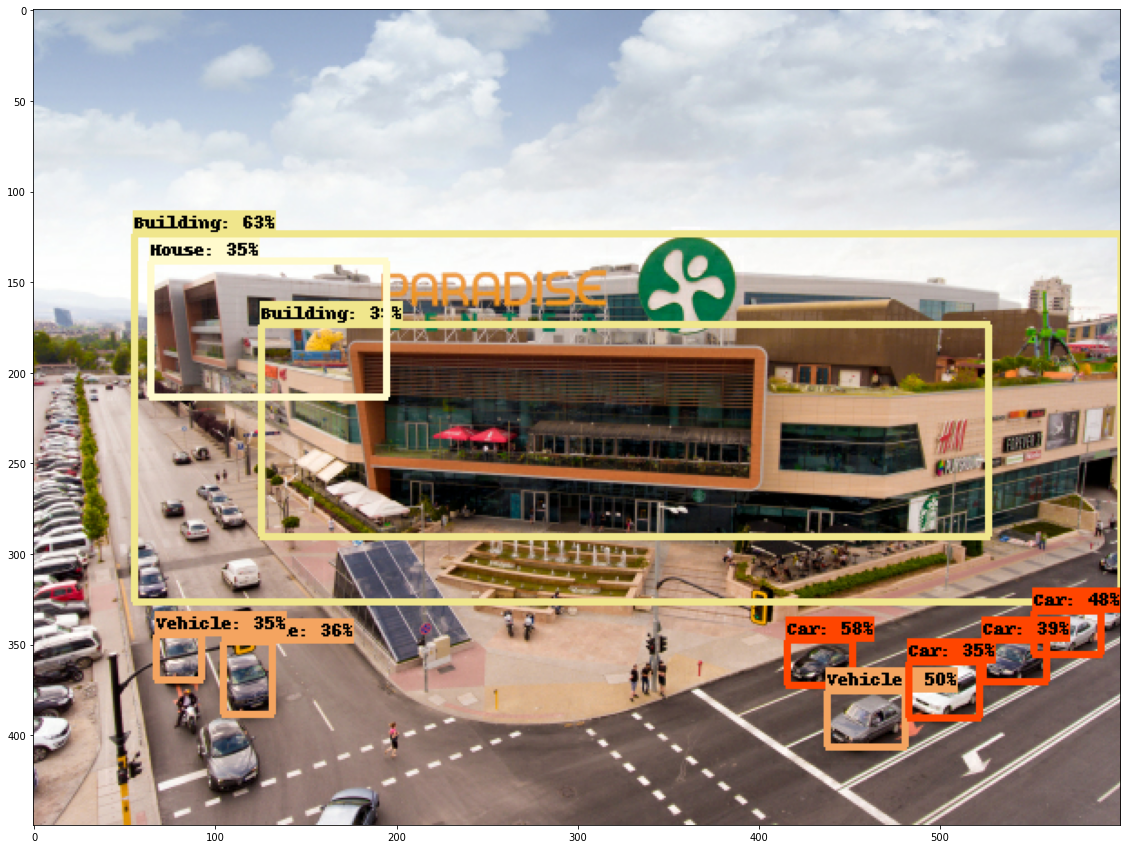

In [50]:
detect_img_by_path("D:\ML AI test\AI Factory\krustovishte.jpeg")